In [239]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
np.set_printoptions(precision=4, suppress=True)
plt.rcParams.update({'font.size': 10})
%run static_aggregators.ipynb
%run surrogate_score.ipynb

In [2]:
save_file = open('data0928/daily_data_matrix_all_0928.npy','rb')
raw_indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
raw_user_id = np.load(save_file)
raw_preds_age = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("data0928/ifps0928_refined.csv")
raw_ifps_type = ifps_data['type'].values
labels = ["HRL vol", "HRL turk", 'ctrl vol', 'ctrl turk']

In [82]:
def corr(x, y):
    notnan_x = ~np.isnan(x)
    notnan_y = ~np.isnan(y)
    x = x[notnan_x & notnan_y]
    y = y[notnan_x & notnan_y]
    return st.pearsonr(x, y)

def marked_invalid_data_as_nan(data, openday):
    data = np.array(data, dtype=float)
    data[data<-0.1] = np.NAN
    data[openday<1] = np.NAN
    return data

def mean_of_bins(x, y, n_centers, min_x, max_x):
    centers = np.linspace(min_x, max_x, n_centers)
    interval = (max_x - min_x) / (n_centers - 1)
    values = np.zeros(len(centers))
    for i, c in enumerate(centers):
        low = c - interval / 2
        high = c + interval / 2
        values[i] = np.nanmean(y[(x>=low-0.001) & (x<=high+0.001)])
    return  centers, values

def normalize_score(scores, max_score=2, min_score=0):
    min_v = np.nanmin(scores)
    max_v = np.nanmax(scores)
    scores = (scores - min_v) / (max_v - min_v) * (max_score-min_score) + min_score
    return scores

In [3]:
# IFP filter
valid_IFPs = (raw_openday[59, :]>=0) & (~np.isnan(raw_truth)) & (raw_ifps_type==2)
print("Valid IFPs:", np.sum(valid_IFPs))
preds = raw_preds[:, valid_IFPs]
conf = raw_conf[:, valid_IFPs]
se = raw_se[:, valid_IFPs]
openday = raw_openday[:, valid_IFPs]
#preds_age = raw_preds_age[:, valid_IFPs]
ifps_type = raw_ifps_type[valid_IFPs]
truth = raw_truth[valid_IFPs]
print("IFP filter complete!")

# User filter
valid_users = raw_user_type==2

preds = preds[:, :, valid_users]
conf = conf[:, :, valid_users]
se = se[:, :, valid_users]
#preds_age = raw_preds_age[:, valid_IFPs, valid_users]
user_type = raw_user_type[valid_users]
print(se.shape, conf.shape)

print("User type filter complete!")

marked_preds = marked_invalid_data_as_nan(preds, openday)
marked_conf = marked_invalid_data_as_nan(conf, openday)
marked_se = marked_invalid_data_as_nan(se, openday)

#rel_marked_se = marked_se - np.nanmedian(marked_se, axis=2)[:, :, None]
print("Set invalid value as NAN complete!")

Valid IFPs: 81
IFP filter complete!
(185, 81, 768) (185, 81, 768)
User type filter complete!
Set invalid value as NAN complete!


In [213]:
t, n, m, o = preds.shape
final_conf_per_IFP_user = np.NAN * np.ones((n,m))
final_preds_per_IFP_user = np.NAN * np.ones((n,m,o))
final_BS_per_IFP_user = np.NAN * np.ones((n,m))
last_day_per_IFP = np.argmax(openday, axis=0)
for i in range(n):
    if openday[last_day_per_IFP[i], i]<=0: continue
    final_conf_per_IFP_user[i] = marked_conf[last_day_per_IFP[i], i]
    final_preds_per_IFP_user[i] = marked_preds[last_day_per_IFP[i], i, :, :]
    final_BS_per_IFP_user[i] = marked_se[last_day_per_IFP[i], i, :]
    
valid_IFPs = np.ones(n, dtype=bool)
valid_users = np.ones(m, dtype=bool)
n_valid_IFPs = n
n_valid_users = m

while (True):
    valid_IFPs = np.sum(~np.isnan(final_preds_per_IFP_user[:, valid_users, 0]), axis=1)>=30
    valid_users = np.sum(~np.isnan(final_preds_per_IFP_user[valid_IFPs, :, 0]), axis=0)>=15
    tmp1 = np.sum(valid_IFPs)
    tmp2 = np.sum(valid_users)
    print(np.sum(valid_IFPs), np.sum(valid_users))
    if n_valid_IFPs == tmp1 and n_valid_users == tmp2: break
    else: 
        n_valid_IFPs = tmp1
        n_valid_users = tmp2
          
print(valid_IFPs.shape, valid_users.shape, n, m, final_conf_per_IFP_user.shape)
final_conf_per_IFP_user = final_conf_per_IFP_user[valid_IFPs][:, valid_users]
final_preds_per_IFP_user = final_preds_per_IFP_user[valid_IFPs][:, valid_users]
final_BS_per_IFP_user = final_BS_per_IFP_user[valid_IFPs][:, valid_users]
last_day_per_IFP = last_day_per_IFP[valid_IFPs]
truth_per_IFP = truth[valid_IFPs]
type_per_IFP = ifps_type[valid_IFPs]

n, m, o = final_preds_per_IFP_user.shape
print("Second filter on IFPs and users complete!")
#random relabeling
n, m, o = final_preds_per_IFP_user.shape
for i in range(n):
    n_outcome = type_per_IFP[i]
    order = np.arange(n_outcome)
    #np.random.shuffle(order)
    final_preds_per_IFP_user[i, :, :n_outcome] = final_preds_per_IFP_user[i][:, order]
    truth_per_IFP[i] = np.argwhere(order==truth_per_IFP[i]-1)+1
print("Label shuffling complete!")
print(truth_per_IFP)

69 484
68 484
68 484
(81,) (768,) 81 768 (81, 768)
Second filter on IFPs and users complete!
Label shuffling complete!
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  1.  2.  2.  1.  1.  2.  2.
  1.  2.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.
  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.]


In [214]:
vote_per_IFP_user = np.argmax(final_preds_per_IFP_user, axis=-1)
vote_per_IFP_user[np.isnan(final_preds_per_IFP_user[:,:,0])] = -1


votes_per_IFP = np.zeros((n,o))
for i in range(n):
    for k in range(o):
        votes_per_IFP[i,k] = np.sum(vote_per_IFP_user[i]==k)


#print(votes_per_IFP.shape)
#print(vote_per_IFP_user)
#print(votes_per_IFP)   

#majority_vote_per_IFP = np.argmax(votes_per_IFP, axis=-1)
#majority_users_per_IFP = vote_per_IFP_user - majority_vote_per_IFP[:, None] == 0
#majority_correct_IFPs = majority_vote_per_IFP == (truth_per_IFP-1) 
#consensus_per_IFP = np.max(votes_per_IFP, axis=-1) / np.sum(votes_per_IFP, axis=-1)

In [215]:
# Benchmark aggregation


n, m, o = final_preds_per_IFP_user.shape
curr_pred = np.array(final_preds_per_IFP_user)
#curr_wager = np.array(wager)
curr_conf = np.array(final_conf_per_IFP_user)


mean_pred = mean_aggr(curr_pred)
median_pred = median_aggr(curr_pred)
logit_pred = logit_aggr(curr_pred, ifps_type=type_per_IFP)
Bayesian_pred = Bayesian_aggr(curr_pred, ifps_type=type_per_IFP)
major_pred = majority_aggr(curr_pred)

truth_per_IFP = truth_per_IFP.astype(int)
MBS_mean, BS_mean = MBS(mean_pred, truth_per_IFP)
MBS_median, BS_median = MBS(median_pred, truth_per_IFP)
MBS_logit, BS_logit = MBS(logit_pred, truth_per_IFP)
MBS_Bayesian, BS_Bayesian = MBS(Bayesian_pred, truth_per_IFP)
MBS_major, BS_major = MBS(major_pred, truth_per_IFP)


print(np.array([MBS_mean, MBS_median, MBS_logit, MBS_Bayesian, MBS_major
               ])
     )

[ 0.2068  0.1514  0.1342  0.2647  0.2353]


68 484
0.36335754162 0.156224916746 1
0.295347432633 0.175009388442 1
0.293973215294 0.175216716664 1
0.286760793083 0.174678371251 1
0.348949278445 0.161108957785 1
0.30191536415 0.173532545159 1
0.289119695801 0.171835605815 1
0.327705658278 0.16551353462 1
0.280795382804 0.177560057861 1
0.378067799987 0.154964010445 1
0.319801980529 0.171489803029 1
0.316890376602 0.168830355256
nan nan
Estimated e0,e1,P0:~ 0.316890376602 0.168830355256 0.255739618694
(68, 484)
(0.88839076850502297, 4.4179081863293701e-165)


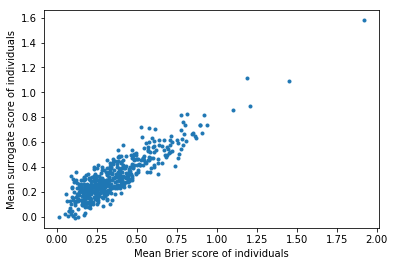

In [251]:
%run surrogate_score.ipynb
def get_surrogate_score(pred_matrix, P0=0.51, trials = 100):
    # pred_matrix should be a single probability for each IFP and each user, can be NAN
    # for surrogate error rate implementation, the label should be 1 for True and 2 for False
    
    n, m = pred_matrix.shape
    
    #crowd_err, P0_est = sur_error_rate_of_average_individual(pred_matrix, P0=P0)
    # Generate rate a good forecaster and many label realizations of its prob. forecasts over all events
    agg_pred = np.nanmean(pred_matrix, axis=-1)
    #agg_pred = np.array(pred_matrix)
    #agg_pred[agg_pred>=1] = 0.999
    #agg_pred[agg_pred<=0] = 0.001
    #agg_pred = np.log(agg_pred/(1-agg_pred))
    #agg_pred = 1.4 * np.nanmean(agg_pred, axis=-1)
    #agg_pred = 1/(1+np.exp(-agg_pred))
    #agg_pred = np.random.rand(n)
    #print(agg_pred)
    

    agg_labels_multi_trials = np.zeros((n, trials))
    rands_in_0_to_1 = np.random.rand(n, trials)
    agg_labels_multi_trials = rands_in_0_to_1 < agg_pred[:, None]
    
    # Evaluate the error rate of the forecaster we generate using the crowds predictions and 
    # the multiple realizations of its prob forecasts as labels over all events
    err_each_trial, P0_est = sur_error_rate(pred_matrix, eval_labels=agg_labels_multi_trials, P0=P0)    
    # The eval_lables parameter is labels in 1, 2, where 1 is true
    
    err_each_trial = np.array(err_each_trial)
    err_agg = np.mean(err_each_trial, axis=0)
    
    #print(err_agg)
    
    # Use the aggregate forecasts and the error rate to evalute the surrogate scores of the crowds of each event
    return estimate_sur_score(pred_matrix, agg_pred, err_agg)
    #return estimate_sur_score_from_crowds(pred_matrix, pred_matrix, crowd_err)

sur_score_per_IFP_user = get_surrogate_score(final_preds_per_IFP_user[:, :, 1], P0=0.49)
print(sur_score_per_IFP_user.shape)
x = np.nanmean(final_BS_per_IFP_user, axis=0)
y = np.nanmean(sur_score_per_IFP_user, axis=0)
print(corr(x, y))
plt.figure()
plt.plot(np.nanmean(final_BS_per_IFP_user, axis=0), np.nanmean(sur_score_per_IFP_user, axis=0), '.')
plt.xlabel("Mean Brier score of individuals")
plt.ylabel("Mean surrogate score of individuals")
plt.show()
plt.close('All')
sur_score_per_IFP_user = normalize_score(sur_score_per_IFP_user)

(0.93665552672298702, 9.5480179051536463e-222)


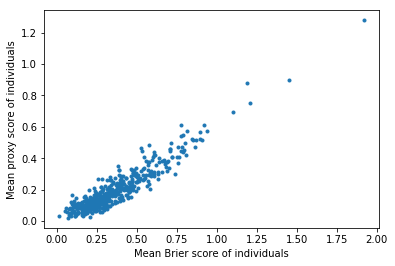

In [247]:
def get_proxy_score(pred_matrix, extreme_coef=2):
    n, m, o = pred_matrix.shape
    # Generate rate a good aggregated prediction for each IFP
    agg_pred = np.nanmean(pred_matrix, axis=1)
    agg_pred = agg_pred**extreme_coef
    agg_pred = agg_pred / np.sum(agg_pred, axis=-1)[:, None]
    
    score_matrix = np.sum((pred_matrix - agg_pred[:, None,:])**2, axis=-1)
    return score_matrix

proxy_score_per_IFP_user = get_proxy_score(final_preds_per_IFP_user)
x = np.nanmean(final_BS_per_IFP_user, axis=0)
y = np.nanmean(proxy_score_per_IFP_user, axis=0)
print(corr(x, y))
plt.figure()
plt.plot(np.nanmean(final_BS_per_IFP_user, axis=0), np.nanmean(proxy_score_per_IFP_user, axis=0), '.')
plt.xlabel("Mean Brier score of individuals")
plt.ylabel("Mean proxy score of individuals")
plt.show()
plt.close('All')
proxy_score_per_IFP_user = normalize_score(proxy_score_per_IFP_user)

(484,)


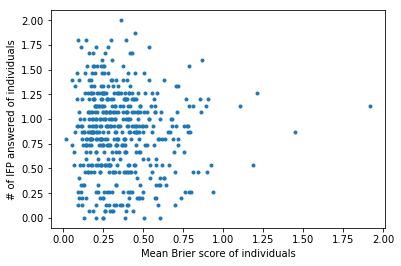

In [221]:
num_of_answered_IFPs_score_per_user = np.sum(np.isnan(final_preds_per_IFP_user[:, :, 0]), axis=0)
print(num_of_answered_IFPs_score_per_user.shape)
num_of_answered_IFPs_score_per_user = normalize_score(-num_of_answered_IFPs_score_per_user)
plt.figure()
plt.plot(np.nanmean(final_BS_per_IFP_user, axis=0), num_of_answered_IFPs_score_per_user, '.')
plt.xlabel("Mean Brier score of individuals")
plt.ylabel("# of IFP answered of individuals")
plt.show()
plt.close('All')

(68, 484, 5) (68,)
[[ 0.      0.      0.      0.      0.    ]
 [    nan     nan     nan     nan     nan]
 [ 0.3074  0.6926     nan     nan     nan]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


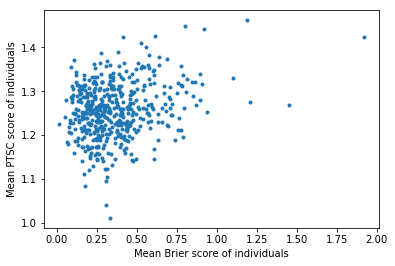

In [223]:
def get_PTSC_score(pred_matrix, type_per_IFP, truth_per_IFP=None):
    n, m, o = pred_matrix.shape
    print(pred_matrix.shape, type_per_IFP.shape)
    vote_per_IFP_user = np.argmax(pred_matrix, axis=-1)
    vote_per_IFP_user[np.isnan(pred_matrix[:,:,0])] = -1

    votes_per_IFP = np.zeros((n,o))
    for i in range(n):
        for k in range(o):
            votes_per_IFP[i,k] = np.sum(vote_per_IFP_user[i]==k)
    total_votes_per_IFP = np.sum(votes_per_IFP, axis=-1)
        
    prior_vote_per_IFP_type = np.NAN * np.ones((o+1, o))
    for k in range(2, o+1):
        prior_vote_per_IFP_type[k, :k] = np.sum(votes_per_IFP[type_per_IFP==k, :k], axis=0)
        print(np.sum(votes_per_IFP[type_per_IFP==k, :], axis=0))
        prior_vote_per_IFP_type[k] = prior_vote_per_IFP_type[k]/np.nansum(prior_vote_per_IFP_type[k])
      
    print(prior_vote_per_IFP_type)
    #print(prior_vote_per_IFP_type[type_per_IFP].shape)
    #print(((votes_per_IFP-1)/(total_votes_per_IFP[:, None]-1)).shape)
    #print((votes_per_IFP-1)/(total_votes_per_IFP[:, None]-1))

    score_matrix = np.NAN * np.ones((n, m))
    score_per_IFP_vote = (votes_per_IFP-1)/(total_votes_per_IFP[:, None]-1)/prior_vote_per_IFP_type[type_per_IFP]
    
    for i in range(n):
        for j in range(m):
            if np.isnan(pred_matrix[i,j,0]): continue
            vote = vote_per_IFP_user[i, j]
            score_matrix[i, j] = score_per_IFP_vote[i, vote]
        
    score_matrix = np.nanmax(score_matrix) - score_matrix
    return score_matrix
PTSC_score_per_IFP_user = get_PTSC_score(final_preds_per_IFP_user, type_per_IFP, truth_per_IFP)
PTSC_score_per_IFP_user = normalize_score(PTSC_score_per_IFP_user)
plt.figure()
plt.plot(np.nanmean(final_BS_per_IFP_user, axis=0), np.nanmean(PTSC_score_per_IFP_user, axis=0), '.')
plt.xlabel("Mean Brier score of individuals")
plt.ylabel("Mean PTSC score of individuals")
plt.show()
plt.close('All')


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


[ 1.5495  1.3277  1.0695  1.5105  1.6566  1.6006  1.2594  1.5485  1.7701
  0.794   1.5047  1.6803  1.5935  1.5798  1.3445  0.5115  1.3675  1.6877
  1.414   0.5716  1.4096  1.3394  1.271   1.2458  1.1733  1.3296  1.5767
  1.3916  1.6221  1.3606  1.129   1.4337  1.3338  1.7445  1.2367  0.4396
  1.3185  1.123   1.8543  1.5174  0.8591  1.3714  0.5859  0.4541  1.2598
  1.2413  1.7607  1.4206  1.186   1.3957  1.037   1.4265  1.2759  1.4073
  0.7462  1.7194  1.5627  1.7044  1.426   0.6093  1.2626  1.7221  1.6246
  0.9692  1.1193  1.4851  1.4511  1.2952  1.511   0.9603  1.4469  1.156
  0.9234  1.457   1.3941  1.5483  1.3391  1.3772  1.0365  0.9222  0.4987
  1.2831  0.7696  0.376   1.4178  1.3349  1.2919  1.7346  1.4359  1.3815
  1.5895  1.0057  1.2605  1.4593  1.6593  0.9191  1.7351  1.5046  1.3892
  0.9658  1.2279  1.5282  1.4583  1.4291  0.3195  1.5478  1.0231  1.3341
  1.4605  1.4821  1.8013  1.6588  1.4086  0.7591  1.2883  1.4813  1.547
  1.0391  1.3156  1.3576  1.589   1.2578  1.4351  1.0

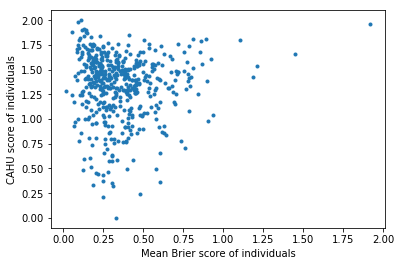

In [224]:
def get_CAHU_score(pred_matrix, type_per_IFP, truth_per_IFP=None):
    n, m, o = pred_matrix.shape
    vote_per_IFP_user = np.argmax(pred_matrix, axis=-1)
    vote_per_IFP_user[np.isnan(pred_matrix[:,:,0])] = -1

    votes_per_IFP = np.zeros((n,o))
    for i in range(n):
        for k in range(o):
            votes_per_IFP[i,k] = np.sum(vote_per_IFP_user[i]==k)
    total_votes_per_IFP = np.sum(votes_per_IFP, axis=-1)
    vote_per_IFP_user_outcome = np.zeros((m, o, n), dtype=bool)
    for j in range(m):
        for k in range(o):
            vote_per_IFP_user_outcome[j, k, :] = vote_per_IFP_user[:, j] == k
            
    for curr_type in range(2, int(np.max(type_per_IFP))+1):
        curr_preds = pred_matrix[type_per_IFP==curr_type]
        curr_votes = vote_per_IFP_user_outcome[:, :, type_per_IFP==curr_type][:, :curr_type, :]
        marginal_vote_per_user = np.sum(curr_votes, axis=-1)
        marginal_vote_per_user = marginal_vote_per_user/(np.sum(marginal_vote_per_user, axis=-1)[:, None])
        
        joint_vote_per_user_pair = np.NAN * np.zeros((m,m,curr_type, curr_type))
        delta_matrix_per_user_pair = np.NAN * np.zeros((m,m,curr_type, curr_type))
        for i1 in range(m-1):
            for i2 in range(i1+1, m):
                for k1 in range(curr_type):
                    for k2 in range(curr_type):
                        tmp = np.sum(vote_per_IFP_user_outcome[i1, k1] & vote_per_IFP_user_outcome[i2, k2])
                        joint_vote_per_user_pair[i1, i2, k1, k2] = tmp
                        joint_vote_per_user_pair[i2, i1, k2, k1] = tmp
                tmp_sum = np.sum(joint_vote_per_user_pair[i1, i2])
                #if tmp_sum<20: continue
                delta_matrix_per_user_pair[i1, i2] = (joint_vote_per_user_pair[i1, i2]/tmp_sum
                                                      -(marginal_vote_per_user[i1][:, None]
                                                        @ marginal_vote_per_user[i2][None, ])
                                                     )
                delta_matrix_per_user_pair[i2, i1] = delta_matrix_per_user_pair[i1, i2].T
                #print(delta_matrix_per_user_pair[i1, i2])

        delta_matrix_per_user_pair[delta_matrix_per_user_pair<=0] = 0
        sum_of_delta_matrix = np.sum(delta_matrix_per_user_pair, axis=(-1,-2))
        
        score_vector = np.nanmean(sum_of_delta_matrix, axis=-1)
        score_vector = np.nanmax(score_vector) - score_vector
    return score_vector
CAHU_score_per_user = get_CAHU_score(final_preds_per_IFP_user, type_per_IFP, truth_per_IFP)
CAHU_score_per_user = normalize_score(CAHU_score_per_user)
print(CAHU_score_per_user)
plt.figure()
plt.plot(np.nanmean(final_BS_per_IFP_user, axis=0), CAHU_score_per_user, '.')
plt.xlabel("Mean Brier score of individuals")
plt.ylabel("CAHU score of individuals")
plt.show()
plt.close('All')


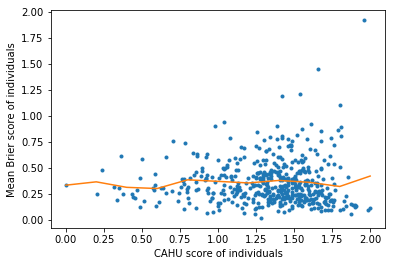

In [225]:
mean_BS_per_user = np.nanmean(final_BS_per_IFP_user, axis=0)
centers, values = mean_of_bins(CAHU_score_per_user, mean_BS_per_user, 11, 0, 2.0)
plt.figure()
plt.plot(CAHU_score_per_user, mean_BS_per_user, '.')
plt.plot(centers, values)
plt.xlabel("CAHU score of individuals")
plt.ylabel("Mean Brier score of individuals")
plt.show()
plt.close('All')

In [226]:
def score_weighted_aggr(preds, sur_scores, 
                        score_mode="abs",
                        score_aggregate_method="mean", 
                        pred_aggregate_method="mean",
                        use_score_as_weight=False,
                        score_as_weight_mode="power",
                        score_as_weight_coef=2,
                        top_user_mode="percent",
                        top_user_value=1,
                        median_shrink_factor=None,
                        ifps_type=None):
    n, m, o = preds.shape
    if ifps_type is None:
        ifps_type = 2 * np.ones(n)
        
    if len(sur_scores.shape)>=2:
        scaled_scores = 2 - sur_scores
        if score_mode=="rel" or score_mode=="relative":
            if median_shrink_factor is None: 
                print("Provide median_shrink_factor")
                return 
            else:
                scaled_scores = scaled_scores - 0.6 * np.nanmedian(scaled_scores, axis=-1)[:, None]
      
        if score_aggregate_method=="mean":
            scores_per_user = np.nanmean(scaled_scores, axis=0)
        elif score_aggregate_method=="sum":
            scores_per_user = np.nansum(scaled_scores, axis=0) 
    else: scores_per_user = 2 - np.array(sur_scores)
        
    agg_preds = np.NAN * np.ones((n, o))
    for i in range(n):
        valid_users = ~np.isnan(preds[i, :, 0])
        n_valid_users = np.sum(valid_users)
        curr_preds = preds[i, valid_users]
        weights = scores_per_user[valid_users]
        
        order = np.argsort(weights)
        curr_preds = curr_preds[order, :]
        weights = weights[order]
        
        if top_user_mode=="percent":
            n_top = int(top_user_value/100 * n_valid_users)
        elif top_user_mode=="abs":
            n_top = int(np.min([n_valid_users, top_user_value]))
        curr_preds = curr_preds[-n_top:, :]
        weights = weights[-n_top:]
        #weights = np.exp(weights)
        
        if not use_score_as_weight: weights = None
        elif score_as_weight_mode.lower()=="power":
            weights = weights ** score_as_weight_coef
        elif score_as_weight_mode.lower()=="exp":
            weights = np.exp(score_as_weight_coef * weights)
        
        if pred_aggregate_method.lower()=="mean":
            #agg_preds[i, :] = np.average(curr_preds, weights=weights, axis=0)
            agg_preds[i, :] = np.average(curr_preds, weights=weights, axis=0)
        elif pred_aggregate_method.lower()=="median":
            agg_preds[i, :] = np.median(curr_preds, axis=0)
        elif pred_aggregate_method.lower()=="logit":
            agg_preds[i, :] = logit_aggr(curr_preds[None, :, :], weights=weights)
        
    return agg_preds

sur_score_pred = score_weighted_aggr(curr_pred, sur_score_per_IFP_user, 
                                     pred_aggregate_method="logit",
                                     #use_score_as_weight=True,
                                     #score_as_weight_mode="exp",
                                     #score_as_weight_coef=4,
                                     top_user_mode="abs", top_user_value=40)
MBS_SS, BS_SS = MBS(sur_score_pred, truth_per_IFP)

PTSC_score_pred = score_weighted_aggr(curr_pred, PTSC_score_per_IFP_user, 
                                      pred_aggregate_method="logit",
                                      top_user_mode="abs", top_user_value=40)
MBS_PTSC, BS_PTSC = MBS(PTSC_score_pred, truth_per_IFP)

CAHU_score_pred = score_weighted_aggr(curr_pred, CAHU_score_per_user, 
                                      pred_aggregate_method="logit",
                                      top_user_mode="abs", top_user_value=40)
MBS_CAHU, BS_CAHU = MBS(CAHU_score_pred, truth_per_IFP)

mean_BS_per_user = np.nanmean(final_BS_per_IFP_user, axis=0)

print(MBS_SS, MBS_PTSC, MBS_CAHU)

print(np.array([MBS_mean, MBS_median, MBS_logit, MBS_Bayesian, MBS_major
               ])
     )

0.0890780814373 0.153181623828 0.154518574141
[ 0.2068  0.1514  0.1342  0.2647  0.2353]


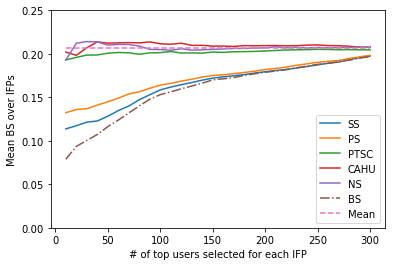

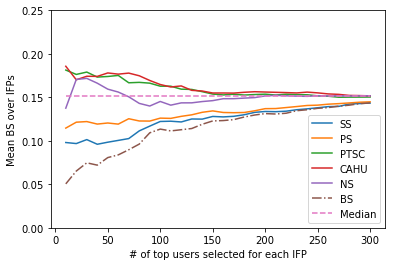

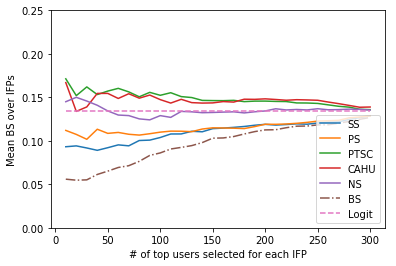

In [227]:
BS_per_IFP_user = normalize_score(final_BS_per_IFP_user)
top_num = np.linspace(10, 300, 30).astype(int)

base_aggr = ['Mean', 'Median', 'Logit']
base_BS = [MBS_mean, MBS_median, MBS_logit]
for base in range(3):
    means_SS, stds_SS = [], []
    means_PS, stds_PS = [], []
    means_PTSC, stds_PTSC = [], []
    means_CAHU, stds_CAHU = [], []
    means_BS, stds_BS = [], []
    means_NS, stds_NS = [], []
    for j in top_num:
        sur_score_pred = score_weighted_aggr(curr_pred, sur_score_per_IFP_user, 
                                             pred_aggregate_method=base_aggr[base],
                                             top_user_mode="abs", top_user_value=j)
        MBS_SS, BS_SS = MBS(sur_score_pred, truth_per_IFP)

        proxy_score_pred = score_weighted_aggr(curr_pred, proxy_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="abs", top_user_value=j)
        MBS_PS, BS_PS = MBS(proxy_score_pred, truth_per_IFP)
        
        PTSC_score_pred = score_weighted_aggr(curr_pred, PTSC_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="abs", top_user_value=j)
        MBS_PTSC, BS_PTSC = MBS(PTSC_score_pred, truth_per_IFP)

        CAHU_score_pred = score_weighted_aggr(curr_pred, CAHU_score_per_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="abs", top_user_value=j)
        MBS_CAHU, BS_CAHU = MBS(CAHU_score_pred, truth_per_IFP)

        Brier_score_pred = score_weighted_aggr(curr_pred, BS_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="abs", top_user_value=j)
        MBS_BS, BS_BS = MBS(Brier_score_pred, truth_per_IFP)
        
        NS_pred = score_weighted_aggr(curr_pred, num_of_answered_IFPs_score_per_user, 
                                      pred_aggregate_method=base_aggr[base],
                                      top_user_mode="abs", top_user_value=j)
        MBS_NS, BS_NS = MBS(NS_pred, truth_per_IFP)

        means_SS.append(MBS_SS)
        means_PS.append(MBS_PS)
        means_PTSC.append(MBS_PTSC)
        means_CAHU.append(MBS_CAHU)
        means_BS.append(MBS_BS)
        means_NS.append(MBS_NS)
        stds_SS.append(np.nanstd(BS_SS))
        stds_PS.append(np.nanstd(BS_PS))
        stds_PTSC.append(np.nanstd(BS_PTSC))
        stds_CAHU.append(np.nanstd(BS_CAHU))
        stds_BS.append(np.nanstd(BS_BS))
        stds_NS.append(np.nanstd(BS_NS))

    plt.figure()
    #plt.errorbar(top_num, means_SS, yerr=stds_SS)
    plt.plot(top_num, means_SS, label='SS')
    plt.plot(top_num, means_PS, label='PS')
    plt.plot(top_num, means_PTSC, label='PTSC')
    plt.plot(top_num, means_CAHU, label='CAHU')
    plt.plot(top_num, means_NS, label='NS')
    plt.plot(top_num, means_BS, '-.', label='BS')
    plt.plot(top_num, base_BS[base] * np.ones_like(top_num), '--', label=base_aggr[base])
    plt.xlabel("# of top users selected for each IFP")
    plt.ylabel("Mean BS over IFPs")
    plt.legend()
    plt.ylim([0, 0.25])
    #plt.savefig("abs_top_"+base_aggr[base]+".jpg", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close('All')



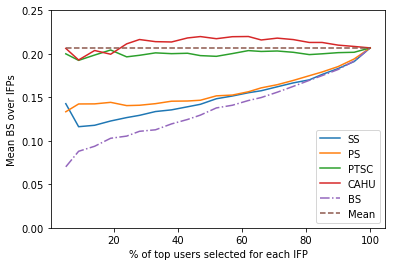

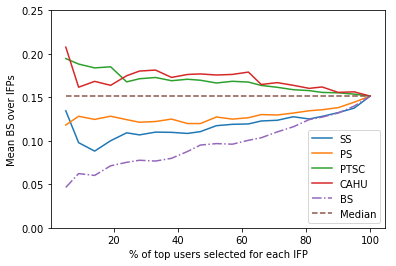

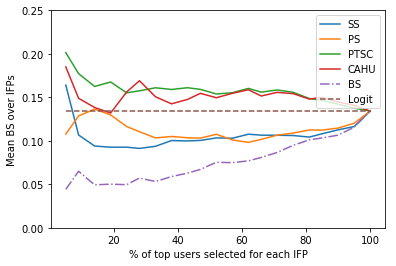

In [ ]:
BS_per_IFP_user = normalize_score(final_BS_per_IFP_user)
top_num = np.linspace(5, 100, 21).astype(int)

base_aggr = ['Mean', 'Median', 'Logit']
base_BS = [MBS_mean, MBS_median, MBS_logit]
for base in range(3):
    means_SS, stds_SS = [], []
    means_PS, stds_PS = [], []
    means_PTSC, stds_PTSC = [], []
    means_CAHU, stds_CAHU = [], []
    means_BS, stds_BS = [], []
    for j in top_num:
        sur_score_pred = score_weighted_aggr(curr_pred, sur_score_per_IFP_user, 
                                             pred_aggregate_method=base_aggr[base],
                                             top_user_mode="percent", top_user_value=j)
        MBS_SS, BS_SS = MBS(sur_score_pred, truth_per_IFP)

        proxy_score_pred = score_weighted_aggr(curr_pred, proxy_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="percent", top_user_value=j)
        MBS_PS, BS_PS = MBS(proxy_score_pred, truth_per_IFP)
        
        PTSC_score_pred = score_weighted_aggr(curr_pred, PTSC_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="percent", top_user_value=j)
        MBS_PTSC, BS_PTSC = MBS(PTSC_score_pred, truth_per_IFP)

        CAHU_score_pred = score_weighted_aggr(curr_pred, CAHU_score_per_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="percent", top_user_value=j)
        MBS_CAHU, BS_CAHU = MBS(CAHU_score_pred, truth_per_IFP)

        Brier_score_pred = score_weighted_aggr(curr_pred, BS_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              top_user_mode="percent", top_user_value=j)
        MBS_BS, BS_BS = MBS(Brier_score_pred, truth_per_IFP)

        means_SS.append(MBS_SS)
        means_PS.append(MBS_PS)
        means_PTSC.append(MBS_PTSC)
        means_CAHU.append(MBS_CAHU)
        means_BS.append(MBS_BS)
        stds_SS.append(np.nanstd(BS_SS))
        stds_PS.append(np.nanstd(BS_PS))
        stds_PTSC.append(np.nanstd(BS_PTSC))
        stds_CAHU.append(np.nanstd(BS_CAHU))
        stds_BS.append(np.nanstd(BS_BS))

    plt.figure()
    #plt.errorbar(top_num, means_SS, yerr=stds_SS)
    plt.plot(top_num, means_SS, label='SS')
    plt.plot(top_num, means_PS, label='PS')
    plt.plot(top_num, means_PTSC, label='PTSC')
    plt.plot(top_num, means_CAHU, label='CAHU')
    plt.plot(top_num, means_BS, '-.', label='BS')
    plt.plot(top_num, base_BS[base] * np.ones_like(top_num), '--', label=base_aggr[base])
    plt.xlabel("% of top users selected for each IFP")
    plt.ylabel("Mean BS over IFPs")
    plt.legend()
    plt.ylim([0, 0.25])
    plt.savefig("percent_top_"+base_aggr[base]+".jpg", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close('All')




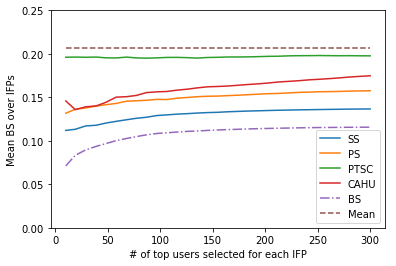

In [ ]:
BS_per_IFP_user = normalize_score(final_BS_per_IFP_user)
top_num = np.linspace(10, 300, 31).astype(int)

base_aggr = ['Mean', 'Logit']
base_BS = [MBS_mean, MBS_median, MBS_logit]
for base in range(len(base_aggr)):
    means_SS, stds_SS = [], []
    means_PS, stds_PS = [], []
    means_PTSC, stds_PTSC = [], []
    means_CAHU, stds_CAHU = [], []
    means_BS, stds_BS = [], []
    for j in top_num:
        sur_score_pred = score_weighted_aggr(curr_pred, sur_score_per_IFP_user, 
                                             pred_aggregate_method=base_aggr[base],
                                             use_score_as_weight=True,
                                             score_as_weight_mode="exp",
                                             score_as_weight_coef=10,
                                             top_user_mode="abs", top_user_value=j)
        MBS_SS, BS_SS = MBS(sur_score_pred, truth_per_IFP)

        proxy_score_pred = score_weighted_aggr(curr_pred, proxy_score_per_IFP_user, 
                                               pred_aggregate_method=base_aggr[base],
                                               use_score_as_weight=True,
                                               score_as_weight_mode="exp",
                                               score_as_weight_coef=10,
                                               top_user_mode="abs", top_user_value=j)
        MBS_PS, BS_PS = MBS(proxy_score_pred, truth_per_IFP)
        
        PTSC_score_pred = score_weighted_aggr(curr_pred, PTSC_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              use_score_as_weight=True,
                                              score_as_weight_mode="exp",
                                              score_as_weight_coef=10,
                                              top_user_mode="abs", top_user_value=j)
        MBS_PTSC, BS_PTSC = MBS(PTSC_score_pred, truth_per_IFP)

        CAHU_score_pred = score_weighted_aggr(curr_pred, CAHU_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              use_score_as_weight=True,
                                              score_as_weight_mode="exp",
                                              score_as_weight_coef=10,
                                              top_user_mode="abs", top_user_value=j)
        MBS_CAHU, BS_CAHU = MBS(CAHU_score_pred, truth_per_IFP)

        Brier_score_pred = score_weighted_aggr(curr_pred, BS_per_IFP_user, 
                                               pred_aggregate_method=base_aggr[base],
                                               use_score_as_weight=True,
                                               score_as_weight_mode="exp",
                                               score_as_weight_coef=10,
                                               top_user_mode="abs", top_user_value=j)
        MBS_BS, BS_BS = MBS(Brier_score_pred, truth_per_IFP)

        means_SS.append(MBS_SS)
        means_PS.append(MBS_PS)
        means_PTSC.append(MBS_PTSC)
        means_CAHU.append(MBS_CAHU)
        means_BS.append(MBS_BS)
        stds_SS.append(np.nanstd(BS_SS))
        stds_PS.append(np.nanstd(BS_PS))
        stds_PTSC.append(np.nanstd(BS_PTSC))
        stds_CAHU.append(np.nanstd(BS_CAHU))
        stds_BS.append(np.nanstd(BS_BS))

    plt.figure()
    plt.plot(top_num, means_SS, label='SS')
    plt.plot(top_num, means_PS, label='PS')
    plt.plot(top_num, means_PTSC, label='PTSC')
    plt.plot(top_num, means_CAHU, label='CAHU')
    plt.plot(top_num, means_BS, '-.', label='BS')
    plt.plot(top_num, base_BS[base] * np.ones_like(top_num), '--', label=base_aggr[base])
    plt.xlabel("# of top users selected for each IFP")
    plt.ylabel("Mean BS over IFPs")
    plt.legend()
    plt.ylim([0, 0.25])
    plt.savefig("abs_top_weighted"+base_aggr[base]+".jpg", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close('All')




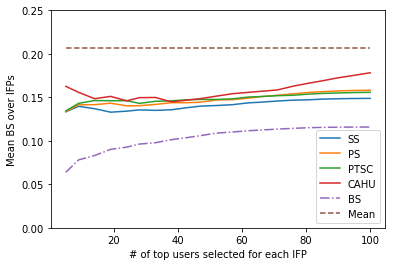

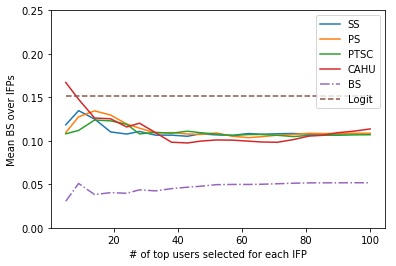

In [207]:
BS_per_IFP_user = normalize_score(final_BS_per_IFP_user)
top_num = np.linspace(5, 100, 21).astype(int)

base_aggr = ['Mean', 'Logit']
base_BS = [MBS_mean, MBS_median, MBS_logit]
for base in range(len(base_aggr)):
    means_SS, stds_SS = [], []
    means_PS, stds_PS = [], []
    means_PTSC, stds_PTSC = [], []
    means_CAHU, stds_CAHU = [], []
    means_BS, stds_BS = [], []
    for j in top_num:
        sur_score_pred = score_weighted_aggr(curr_pred, sur_score_per_IFP_user, 
                                             pred_aggregate_method=base_aggr[base],
                                             use_score_as_weight=True,
                                             score_as_weight_mode="exp",
                                             score_as_weight_coef=10,
                                             top_user_mode="percent", top_user_value=j)
        MBS_SS, BS_SS = MBS(sur_score_pred, truth_per_IFP)

        proxy_score_pred = score_weighted_aggr(curr_pred, proxy_score_per_IFP_user, 
                                               pred_aggregate_method=base_aggr[base],
                                               use_score_as_weight=True,
                                               score_as_weight_mode="exp",
                                               score_as_weight_coef=10,
                                               top_user_mode="percent", top_user_value=j)
        MBS_PS, BS_PS = MBS(proxy_score_pred, truth_per_IFP)
        
        PTSC_score_pred = score_weighted_aggr(curr_pred, PTSC_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              use_score_as_weight=True,
                                              score_as_weight_mode="exp",
                                              score_as_weight_coef=10,
                                              top_user_mode="percent", top_user_value=j)
        MBS_PTSC, BS_PTSC = MBS(PTSC_score_pred, truth_per_IFP)

        CAHU_score_pred = score_weighted_aggr(curr_pred, CAHU_score_per_IFP_user, 
                                              pred_aggregate_method=base_aggr[base],
                                              use_score_as_weight=True,
                                              score_as_weight_mode="exp",
                                              score_as_weight_coef=10,
                                              top_user_mode="percent", top_user_value=j)
        MBS_CAHU, BS_CAHU = MBS(CAHU_score_pred, truth_per_IFP)

        Brier_score_pred = score_weighted_aggr(curr_pred, BS_per_IFP_user, 
                                               pred_aggregate_method=base_aggr[base],
                                               use_score_as_weight=True,
                                               score_as_weight_mode="exp",
                                               score_as_weight_coef=10,
                                               top_user_mode="percent", top_user_value=j)
        MBS_BS, BS_BS = MBS(Brier_score_pred, truth_per_IFP)

        means_SS.append(MBS_SS)
        means_PS.append(MBS_PS)
        means_PTSC.append(MBS_PTSC)
        means_CAHU.append(MBS_CAHU)
        means_BS.append(MBS_BS)
        stds_SS.append(np.nanstd(BS_SS))
        stds_PS.append(np.nanstd(BS_PS))
        stds_PTSC.append(np.nanstd(BS_PTSC))
        stds_CAHU.append(np.nanstd(BS_CAHU))
        stds_BS.append(np.nanstd(BS_BS))

    plt.figure()
    plt.plot(top_num, means_SS, label='SS')
    plt.plot(top_num, means_PS, label='PS')
    plt.plot(top_num, means_PTSC, label='PTSC')
    plt.plot(top_num, means_CAHU, label='CAHU')
    plt.plot(top_num, means_BS, '-.', label='BS')
    plt.plot(top_num, base_BS[base] * np.ones_like(top_num), '--', label=base_aggr[base])
    plt.xlabel("# of top users selected for each IFP")
    plt.ylabel("Mean BS over IFPs")
    plt.legend()
    plt.ylim([0, 0.25])
    plt.savefig("percent_top_weighted"+base_aggr[base]+".jpg", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close('All')





In [ ]:
plt.figure()        
valid = type_per_IFP == 2
plt.plot(consensus_per_IFP[majority_correct_IFPs & valid], BS_logit[majority_correct_IFPs & valid], 
         '.b', label='Majority correct IFPs')
plt.plot(consensus_per_IFP[~majority_correct_IFPs & valid], BS_logit[~majority_correct_IFPs & valid], 
         '.r', label='Majority wrong IFPs')

plt.plot(consensus_per_IFP[majority_correct_IFPs & valid], BS_CE[majority_correct_IFPs & valid], 
         'xb', label='Majority correct IFPs')
plt.plot(consensus_per_IFP[~majority_correct_IFPs & valid], BS_CE[~majority_correct_IFPs & valid], 
         'xr', label='Majority wrong IFPs')
plt.xlabel('Consesus')
plt.ylabel('Brier Score')
plt.legend()
plt.show()
plt.close('All')

print(np.mean(BS_logit[(consensus_per_IFP<0.7) & valid]))
print(np.mean(BS_CE[(consensus_per_IFP<0.7) & valid]))
print(np.mean(BS_CE[(consensus_per_IFP<0.7) & valid]) - np.median(BS_logit[(consensus_per_IFP<0.7) & valid]))


diff = BS_CE - BS_logit
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_CE - BS_mean
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_CE - BS_median
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_CE - BS_conf_weighted
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

In [3]:
%run  surrogate_agg.ipynb

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
np.set_printoptions(precision=4, suppress=True)
%run  surrogate_agg.ipynb

save_file = open('daily_HFC_multi_outcome_data_matrix_all.npy','rb')
raw_indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
raw_user_id = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("ifps0726_resolved.csv")
raw_ifps_type = ifps_data['type'].values


save_file = open('daily_HFC_data_matrix_agg.npy','rb')
agg_preds = np.load(save_file)
agg_se = np.load(save_file)
#agg_openday = np.load(save_file)
## Truth a vector of {1,2} where 1 means the event happen with probability 1
#truth = np.load(save_file)
save_file.close()

save_file = open('sur_score_matrix0726.npy','rb')
raw_sur_score_matrix = np.load(save_file)
save_file.close()

save_file = open('sur_ind_error_rate_vector0726.npy','rb')
raw_err_ind = np.load(save_file)
save_file.close()

#preds = np.loadtxt(fname="/Users/heliaguin/Academy/EconCS/GJP_data/preds_matrix.csv", delimiter=',', dtype=float)
#truth = np.loadtxt(fname="/Users/heliaguin/Academy/EconCS/GJP_data/truth_vector.csv", delimiter=',', dtype=int)
#wager = np.ones_like(preds)
#conf = np.ones_like(preds)
#mse = np.ones_like(preds)

In [5]:
preds = raw_preds[-1]
conf = raw_conf[-1]
wager = raw_wager[-1]
se = raw_se[-1]

#valid = raw_user_type==1 #volunteer
#valid = raw_user_type==2 #turker
#valid = raw_user_type==3 #control
valid = raw_user_type>0# all
preds = preds[:, valid]
conf = conf[:, valid]
wager = wager[:, valid]
se = se[:, valid]
sur_score_matrix = raw_sur_score_matrix[:, valid]
err_ind = raw_err_ind[valid]
user_type = raw_user_type[valid]
user_id = raw_user_id[valid]

#valid = raw_ifps_type==2 # Binary
valid = raw_ifps_type>0 # ALL
preds = preds[valid]
conf = conf[valid]
wager = wager[valid]
se = se[valid]
sur_score_matrix = sur_score_matrix[valid]

ifps_type = raw_ifps_type[valid]
truth = raw_truth[valid]


#valid =  (np.sum(preds[:, :, 0]>-0.1, axis=0)>=20)
#preds = preds[:, valid]
#conf = conf[:, valid]
#wager = wager[:, valid]
#se = se[:, valid]
#sur_score_matrix = sur_score_matrix[:, valid]
#err_ind = err_ind[valid]
#user_type = user_type[valid]
#user_id = user_id[valid]


print(ifps_type)
print(truth)
print(preds.shape)
print(conf.shape)
print(wager.shape)
print(se.shape)
print(agg_preds.shape)
#print(openday[35:70].T)
#print(agg_openday[35:70].T)
#print(ifps_data[['map_id','type']])

[5 3 5 5 3 5 5 5 2 5 5 2 5 5 3 5 5 2 2 5 5 5 5 5 5 5 5 2 2 5 2 2 4 2 2 2 2
 2 4 3 2 2 2 2 3 5 2 5 2 2 3 4 3 2 2 3 5 2 3 2 2 3 2 2 5 2 5 2 2 2 3 5 2 2
 5 5 3 2 2 2 5 4 2 5 5 2]
[3 1 4 4 2 5 2 2 2 5 3 2 4 1 2 5 1 1 1 5 4 1 1 3 2 2 5 2 2 3 1 2 4 2 2 1 2
 1 1 2 1 2 2 1 1 3 2 4 2 1 2 1 3 1 1 1 4 1 1 2 1 2 1 1 5 2 3 2 2 2 1 3 2 2
 3 2 1 1 1 1 1 1 1 2 4 1]
(86, 2094, 5)
(86, 2094)
(86, 2094)
(86, 2094)
(184, 26, 47)


In [6]:
from scipy.spatial.distance import cdist, euclidean
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [17]:
def MBS(preds, truth):
    truth = truth - 1
    preds[preds<-0.1] = np.NAN
    #preds_of_true_label = preds[np.arange(len(truth))[:, None], truth[:, None]].squeeze()
    preds_of_true_label = preds[np.arange(len(truth))[:, None], truth[:, None]].flatten()
    score = np.sum(preds**2, axis=-1) - preds_of_true_label**2 + (1-preds_of_true_label)**2
    return np.nanmean(score), score

def mean_aggr(preds):
    return np.nanmean(preds, axis=1)

def median_aggr(preds):
    n, m, k = preds.shape
    median_pred = -np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i, :, 0])
        median_pred[i] = geometric_median(preds[i, users, :])
    return median_pred

def majority_aggr(preds):
    n, m, k = preds.shape
    major_pred = np.zeros((n, k))
    major_pred[np.arange(n)[:, None], np.argmax(np.nanmean(preds, axis=1), axis=-1)[:, None]] = 1.0
    return major_pred

def entropy_matrix(pred_matrix, axis=-1):
    type_matrix = np.zeros_like(pred_matrix)
    type_matrix[pred_matrix<0] = -1
    type_matrix[(pred_matrix>0) & (pred_matrix<1)] = 1
    entropy_matrix = np.array(pred_matrix)
    entropy_matrix[type_matrix<1] = 0.5
    entropy_matrix = -entropy_matrix * np.log(entropy_matrix)
    entropy_matrix[type_matrix==0] = 0
    entropy_matrix[type_matrix==-1] = np.NAN
    return np.sum(entropy_matrix, axis=axis)
    
    
def prob_weighted_aggr(preds, openday):
    n, m = preds.shape
    prob_weighted_pred = -1 * np.ones(n)
    for i in range(n):
        if openday[i]==0: continue
        if (np.sum(preds[i, :]>-0.1)<=0): continue
        probs = preds[i, :]
        probs = probs[probs>-0.1]
        prob_weighted_pred[i] = np.average(probs, weights=np.abs(probs-0.5))
    return prob_weighted_pred

def entropy_weighted_aggr(preds, ifps_type):
    n, m, k = preds.shape
    entr_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_pred = preds[i, users]
        entr_weights = entropy_matrix(curr_pred)
        entr_weights = (np.log(ifps_type[i]) - entr_weights) / np.log(ifps_type[i])
        entr_weights = entr_weights ** 4
        #entr_weights = np.exp(entr_weights) - 1
        entr_weighted_pred[i] = np.average(curr_pred, weights=entr_weights, axis=0)
    return entr_weighted_pred

def top_conf_aggr(preds, conf):
    n, m, k = preds.shape
    conf_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = (~np.isnan(preds[i,:,0])) & (conf[i,:]>50)
        if np.sum(conf[i, :]>=80)>=10:
            users = users & (conf[i, :]>=80)
        elif np.sum(conf[i, :]>=70)>=10:
            users = users & (conf[i, :]>=70)
            #print("conf:", i, 70, np.sum(conf[i, :]>=80))
        else:
            users = users & (conf[i, :]>50)
            #print("conf:", i, 50, np.sum(conf[i, :]>=70))
        if np.sum(users)<=0: continue
        curr_conf = conf[i, users]
        curr_pred = preds[i, users]
        curr_conf = (curr_conf - np.min(curr_conf)) / (np.max(curr_conf)-np.min(curr_conf))
        conf_weighted_pred[i] = np.average(curr_pred, weights=curr_conf, axis=0)
    return conf_weighted_pred

def conf_weighted_aggr(preds, conf):
    n, m, k = preds.shape
    conf_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        curr_conf = conf[i, :]
        #curr_conf[curr_conf<=0.5] = np.NAN
        users = curr_conf>=0
        curr_conf = curr_conf[users]
        if np.sum(curr_conf>=0)<=0: continue
        curr_pred = preds[i, users]
        if np.max(curr_conf)-np.min(curr_conf)>0:
            curr_conf = (curr_conf - np.min(curr_conf)) / (np.max(curr_conf)-np.min(curr_conf))
        conf_weighted_pred[i] = np.average(curr_pred, weights=curr_conf, axis=0)
    return conf_weighted_pred

def wager_weighted_aggr(preds, wager, wager_option, base_weight=0.1):
    n, m, k = preds.shape
    wager_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_wager = wager[i, users]
        curr_wager[curr_wager==100] = 0
        curr_wager = ((curr_wager - np.min(curr_wager)) / (np.max(curr_wager)-np.min(curr_wager)) 
                      + base_weight * wager_option[users])
        if np.sum(curr_wager>0)<=0: continue
        curr_pred = preds[i, users]
        wager_weighted_pred[i] = np.average(curr_pred, weights=curr_wager, axis=0)
    return wager_weighted_pred

def top_wager_aggr(preds, wager, wager_option, base_weight=5):
    n, m, k = preds.shape
    wager_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_wager = wager[i, users]
        curr_wager[curr_wager==100] = base_weight
        curr_wager[curr_wager==0] = base_weight
        num_wagered_users = np.sum(curr_wager>0)
        if num_wagered_users<=0: continue
        order = np.argsort(curr_wager)
        curr_wager[order[:-10]] = 0
        curr_pred = preds[i, users]
        wager_weighted_pred[i] = np.average(curr_pred, weights=curr_wager, axis=0)
    return wager_weighted_pred

def sur_weighted_aggr(preds, sur_score_matrix, ifps_type=None):
    n, m, k = preds.shape
    if ifps_type is None:
        ifps_type = 2 * np.ones(n)
    sur_weighted_pred = -1 * np.ones((n, k))
    #ind_mean_sur_score = np.nanmean(sur_score_matrix, axis=0) 
    scaled_score = np.array(sur_score_matrix) 
    ### for Brier Score
    scaled_score[scaled_score==-1] = np.NAN
    scaled_score = 2-scaled_score
    ### for sur score (sur score contains negetive values)
    #scaled_score = ((np.nanmax(scaled_score, axis=1)[:, None] - scaled_score) / 
    #                (np.nanmax(scaled_score, axis=1)[:, None]-np.nanmin(scaled_score, axis=1)[:, None])) * 2
    
    scaled_score = scaled_score - (np.nanmedian(scaled_score, axis=1)[:, None]
                                   -np.abs(np.nanmedian(scaled_score, axis=1)[:, None])*0.3)
    ind_mean_sur_score = np.nansum(scaled_score, axis=0)
        
    
    for i in range(n):
        curr_pred = preds[i]
        curr_score = np.array(scaled_score)
        curr_score[i, :] = np.NAN
        curr_score = np.nansum(curr_score, axis=0)
        #curr_score = np.array(ind_mean_sur_score)
        curr_score[np.isnan(curr_score) | np.isnan(curr_pred[:, 0])] = -1000
        user_seq = np.argsort(curr_score)
            
        num_answerred_users = np.sum(curr_score>-1000)
        threshold = np.min([np.max([np.min([int(np.ceil(num_answerred_users*0.1)), 15]), 5]),
                            num_answerred_users])
        #print(i, ifps_type[i], num_answerred_users, threshold, np.sum(~np.isnan(ind_mean_sur_score)))
        if threshold<=0: continue
        print(curr_pred[user_seq[-threshold:]][:, 0])
        #print(curr_pred[user_seq[-num_answerred_users:]][:, 0])
        curr_pred = curr_pred[user_seq[-threshold:]]
        weights = curr_score[user_seq[-threshold:]]
        if (np.max(weights)-np.min(weights)!=0.):
            weights = (weights - np.min(weights))/(np.max(weights)-np.min(weights))
        weights = np.exp(weights)
        #sur_weighted_pred[i] = np.average(curr_pred, weights=weights, axis=0)
        sur_weighted_pred[i] = median_aggr(curr_pred[None, :,:]).squeeze()
        #sur_weighted_pred[i] = entropy_weighted_aggr(curr_pred[None, :,:], ifps_type=[ifps_type[i]])
        #sur_weighted_pred[i] = conf_weighted_aggr(curr_pred[None, :,:], 
        #                                          conf[i, user_seq[-threshold:]][None, :])
        print(sur_weighted_pred[i])
    print(np.isnan(scaled_score).any())
    return sur_weighted_pred


In [8]:

def top_Brier_aggr(preds, sur_score_matrix, ifps_type=None, r=0.25):
    n, m, k = preds.shape
    if ifps_type is None:
        ifps_type = 2 * np.ones(n)
    sur_weighted_pred = -1 * np.ones((n, k))
    #ind_mean_sur_score = np.nanmean(sur_score_matrix, axis=0) 
    scaled_score = np.array(sur_score_matrix) 
    ### for Brier Score
    scaled_score[scaled_score<=-1] = np.NAN
    #scaled_score = ((scaled_score - np.nanmin(scaled_score, axis=1)[:, None]) / 
    #                (np.nanmax(scaled_score, axis=1)[:, None]-np.nanmin(scaled_score, axis=1)[:, None]))
    
    
    for i in range(len(scaled_score)):
        print(i, ":::")
        print(scaled_score[i])
    
    ind_mean_sur_score = np.exp(np.nansum(np.log(1-r*scaled_score), axis=0))
    print('Brier Score', ind_mean_sur_score)
    print(ind_mean_sur_score.shape)
        
    
    for i in range(n):
        curr_pred = preds[i]
        curr_score = np.array(ind_mean_sur_score)
        curr_score = curr_score / (1-r * scaled_score[i, :])
        #curr_score = np.array(scaled_score)
        #curr_score[i, :] = np.NAN
        #curr_score = np.exp(np.nansum(np.log(1-r*curr_score), axis=0))
        print(i, ':')
        curr_score[np.isnan(curr_score) | np.isnan(curr_pred[:, 0])] = -1000
        user_seq = np.argsort(curr_score)
            
        num_answerred_users = np.sum(curr_score>-1000)
        threshold = np.min([np.max([np.min([int(np.ceil(num_answerred_users*0.1)), 15]), 5]),
                            num_answerred_users])
        print("threshold: ", threshold)
        #threshold = np.min([np.max([int(np.ceil(num_answerred_users*0.1)), 20]),
        #                    num_answerred_users])
        #print(i, ifps_type[i], num_answerred_users, threshold, np.sum(~np.isnan(ind_mean_sur_score)))
        if threshold<=0: continue
        #print(curr_pred[user_seq[-threshold:]][:, 0])
        #print(curr_pred[user_seq[-num_answerred_users:]][:, 0])
        curr_pred = curr_pred[user_seq[-threshold:]]
        weights = curr_score[user_seq[-threshold:]]
        #print(weights)
        if (np.max(weights)-np.min(weights)!=0.):
            weights = (weights - np.min(weights))/(np.max(weights)-np.min(weights))
        weights = np.exp(weights)
        sur_weighted_pred[i] = np.average(curr_pred, weights=weights, axis=0)
        #sur_weighted_pred[i] = np.mean(curr_pred, axis=0)
        #sur_weighted_pred[i] = median_aggr(curr_pred[None, :,:]).squeeze()
        #sur_weighted_pred[i] = entropy_weighted_aggr(curr_pred[None, :,:], ifps_type=[ifps_type[i]])
        #sur_weighted_pred[i] = conf_weighted_aggr(curr_pred[None, :,:], 
        #                                          conf[i, user_seq[-threshold:]][None, :])
        #print(sur_weighted_pred[i])
    #print(np.isnan(scaled_score).any())
    return sur_weighted_pred

In [9]:
def logit_aggr(preds, ifps_type=None, para={2: 1.4, 3: 1.4, 4: 1.4, 5: 1.4}):
    n, m, k = preds.shape
    if ifps_type is None: ifps_type = 2 * np.ones(n)
    logit_pred = -1 * np.ones((n, k))
    for i in range(n):
        num_outcome = int(ifps_type[i])
        a = para[num_outcome]
        curr_pred = preds[i, preds[i, :, 0]>-0.1, :]
        if (np.sum(curr_pred[:, 0]>-0.1)<=0): continue
        logit_pred[i] = 0
        base_dim = 0#ifps_type[i] - 1
        logits = np.array(curr_pred).T
        logits[base_dim, logits[base_dim]>=1] = 0.999
        logits[base_dim, logits[base_dim]<=0] = 0.001
        logit_pred[i, base_dim] = 1
        for k in range(0, num_outcome):
            if k==base_dim: continue
            logits[k, logits[k]>=1] = 0.999
            logits[k, logits[k]<=0] = 0.001
            logits[k] = np.log(logits[k]/logits[base_dim])
            mean = np.mean(logits[k])
            logit_pred[i, k] = np.exp(a * mean)
        logit_pred[i] = logit_pred[i] / np.sum(logit_pred[i])
        #print("qid: ", i, "type: ", ifps_type[i], "logit: ", logit_pred[i])
        
    return logit_pred

In [18]:
n, m, k = preds.shape
curr_pred = np.array(preds)
curr_pred[curr_pred<-0.1] = np.NAN
curr_wager = np.array(wager)
curr_conf = np.array(conf)

mean_pred = -np.ones((n, k))
median_pred = -np.ones((n, k))
logit_pred = -np.ones((n,k))
entr_weighted_pred = -np.ones((n, k))
conf_weighted_pred = -np.ones((n,k))
wager_weighted_pred = -np.ones((n,k))
top_wager_pred = -np.ones((n,k))
sur_weighted_pred = -np.ones((n,k))
top_Brier_pred = -np.ones((n,k))
sur2_pred = -np.ones((n,k))
major_pred = -np.ones((n,k)) 

nums = np.sum(curr_pred[:, :, 0]>-0.1, axis=1)
print(nums)
answered_ifps = nums>0
curr_pred = curr_pred[answered_ifps]
            
mean_pred[answered_ifps] = mean_aggr(curr_pred)
median_pred[answered_ifps] = median_aggr(curr_pred)
logit_pred[answered_ifps] = logit_aggr(curr_pred[:, :], ifps_type[answered_ifps])
#logit_pred[answered_ifps, 1] = 1 - logit_pred[answered_ifps, 0]
#logit_pred[answered_ifps, 2:] = 0.0
entr_weighted_pred[answered_ifps] = entropy_weighted_aggr(curr_pred, ifps_type[answered_ifps])
conf_weighted_pred[answered_ifps] = top_conf_aggr(curr_pred, conf[answered_ifps,:])
wager_weighted_pred[answered_ifps] = wager_weighted_aggr(curr_pred, wager[answered_ifps,:], user_type<3)
top_wager_pred[answered_ifps] = top_wager_aggr(curr_pred, wager[answered_ifps,:], user_type<3)
sur_weighted_pred[answered_ifps] = sur_weighted_aggr(curr_pred, sur_score_matrix[answered_ifps],
                                                     ifps_type[answered_ifps])
top_Brier_pred[answered_ifps] = sur_weighted_aggr(curr_pred, se[answered_ifps], ifps_type[answered_ifps])
#sur2_pred[answered_ifps] = sur_weighted_pred[answered_ifps]
#binary_ifps = ifps_type[answered_ifps] ==2
valid = ~np.isnan(err_ind[:, 0])

major_pred[answered_ifps] = majority_aggr(curr_pred)

MBS_mean, BS_mean = MBS(mean_pred, truth)
MBS_median, BS_median = MBS(median_pred, truth)
MBS_major, BS_major = MBS(major_pred, truth)
MBS_logit, BS_logit = MBS(logit_pred, truth)
#MBS_prob_weighted[i], BS_prob_weighted[i] = MBS(prob_weighted_pred, truth)
MBS_entr_weighted, BS_entr_weighted = MBS(entr_weighted_pred, truth)
MBS_conf_weighted, BS_conf_weighted = MBS(conf_weighted_pred, truth)
MBS_wager_weighted, BS_wager_weighted = MBS(wager_weighted_pred, truth)
MBS_top_wager, BS_top_wager = MBS(top_wager_pred, truth)
MBS_sur_weighted, BS_sur_weighted = MBS(sur_weighted_pred, truth)
MBS_top_Brier, BS_top_Brier = MBS(top_Brier_pred, truth)
#MBS_sur2, BS_sur2 = MBS(sur2_pred, truth)
#MBS_major, BS_major = MBS(major_pred, truth)

print(np.array([MBS_mean, MBS_median, MBS_logit, MBS_entr_weighted, 
                MBS_conf_weighted, MBS_conf_weighted, MBS_top_wager, MBS_top_wager,
                MBS_sur_weighted, MBS_top_Brier
               ])
     )


#print(BS_sur_weighted[ifps_type==2])
#print(np.mean(BS_sur_weighted[ifps_type==2]))
diff = BS_sur_weighted - BS_mean
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_sur_weighted - BS_median
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_sur_weighted - MBS_major
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)
#print((BS_entr_weighted - BS_sur_weighted))

diff = BS_sur_weighted - BS_logit
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

diff = BS_sur_weighted - BS_entr_weighted
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)
#print((BS_entr_weighted - BS_sur_weighted))

diff = BS_sur_weighted - BS_conf_weighted
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)
#print((BS_entr_weighted - BS_sur_weighted))

diff = BS_sur_weighted - BS_top_wager
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)
#print((BS_entr_weighted - BS_sur_weighted))

diff = BS_sur_weighted - BS_top_Brier
diff = diff[~np.isnan(diff)]
t_score, p_value = st.ttest_1samp(diff, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)
#print((BS_entr_weighted - BS_sur_weighted))

[188  88 122 112  88 450 761 251 402  82 511  92 117 120 124 289  96 134
 103  67 677  68 115  88 198  58  29 262 207 582 148 549 199 294 370  77
 652 123 474 367  71 448  38 394 180 410 300 215 365  90 195 543 317 172
 391 381 333 248 482 310 431 175 182 115  97 124  81 164  58 131 137 182
  98 135 153 242 317 395 174 311 330 241 184 500 411 325]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.]
[ 1.    0.25  1.    1.    0.05  1.    1.    1.    0.07]
[ 1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.      0.      0.0001  0.0028  0.9971]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.    0.98  0.02  0.    0.  ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.]
[ 1.    0.2   0.7   0.    0.35  0.    0.13  0.72  0.2   0.16  0.    0.03
  0.05  0.    0.11]
[ 0.1553  0.7659  0.0759  0.0029  0.    ]
[ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[ 0.0183  0.6996  0.269   0.0105  0.0025]
[ 0.    0.    0.03  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[ 0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.      0.      0.0751  0.5255  0.3994]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.   

[ 0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.]
[ 0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[ 0.  0.  0.  0.  1.]
[ 0.04  0.13  0.84  0.35  0.    0.72  0.    0.03  0.2   1.    0.05  0.16
  0.11  0.    0.  ]
[ 0.1295  0.8068  0.0625  0.0012  0.    ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.    0.99  0.01  0.    0.  ]
[ 0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[ 0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.      0.      0.0751  0.5255  0.3994]
[ 0.05  0.03  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[ 0.0003  0.016   0.9577  0.0256  0.0004]
[ 0.02  0.35  0.25  0.    0.08  0.    0.01  0.55  0.    0.05]
[ 0.0495  0.9505  0.      0.      0.    ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.      0.      0.    

/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
epoch = 200
total_res = np.zeros(8)
for e in range(epoch):
    print(e)
    n, m, k = preds.shape
    curr_pred = np.array(preds)
    curr_pred[curr_pred<-0.1] = np.NAN
    curr_wager = np.array(wager)
    curr_conf = np.array(conf)

    mean_pred = -np.ones((n, k))
    median_pred = -np.ones((n, k))
    logit_pred = -np.ones((n,k))
    entr_weighted_pred = -np.ones((n, k))
    conf_weighted_pred = -np.ones((n,k))
    wager_weighted_pred = -np.ones((n,k))
    top_wager_pred = -np.ones((n,k))
    sur_weighted_pred = -np.ones((n,k))
    top_Brier_pred = -np.ones((n,k))
    sur2_pred = -np.ones((n,k))
    major_pred = -np.ones((n,k)) 

    nums = np.sum(curr_pred[:, :, 0]>-0.1, axis=1)
    answered_ifps = nums>0
    for i in range(len(curr_pred)):
        while (np.sum(curr_pred[i, :, 0]>-0.1)>120):
            index = np.argwhere(curr_pred[i, :, 0]>-0.1)
            curr_pred[i, index[int(np.random.randint(0, len(index)))], :] = np.NAN
    nums = np.sum(curr_pred[:, :, 0]>-0.1, axis=1)
    days = np.array([43,   48,    3,   16,   48,   79,  116,   25,   86,   18,   86,    5,
                     12,   55,   25,   86,   25,   33,   27,    8,  114,    5,   53,   41,
                     75,   33,   34,   65,   95,   82,   36,   88,   60,   88,   58,   16,
                     99,   35,   58,   81,    3,   51,   12,   86,   29,   44,   74,   43,
                     74,   19,   43,   68,   67,    3,   75,   67,   30,   36,   34,   64,
                     23,   15,    0,    7,    7,    7,    7,    7,    4,    7,    6,   16,
                     7,    7,   39,   39,   32,   39,   21,   20,   29,   15,    3,   23,
                     20,   23
                    ])
    answered_ifps = answered_ifps & (days>=14)

    curr_pred = curr_pred[answered_ifps]
                
    mean_pred[answered_ifps] = mean_aggr(curr_pred)
    median_pred[answered_ifps] = median_aggr(curr_pred)
    logit_pred[answered_ifps] = logit_aggr(curr_pred[:, :], ifps_type[answered_ifps])
    entr_weighted_pred[answered_ifps] = entropy_weighted_aggr(curr_pred, ifps_type[answered_ifps])
    conf_weighted_pred[answered_ifps] = top_conf_aggr(curr_pred, conf[answered_ifps,:])
    top_wager_pred[answered_ifps] = top_wager_aggr(curr_pred, wager[answered_ifps,:], user_type<3)

    MBS_mean, BS_mean = MBS(mean_pred, truth)
    MBS_median, BS_median = MBS(median_pred, truth)
    MBS_major, BS_major = MBS(major_pred, truth)
    MBS_logit, BS_logit = MBS(logit_pred, truth)
    MBS_entr_weighted, BS_entr_weighted = MBS(entr_weighted_pred, truth)
    MBS_conf_weighted, BS_conf_weighted = MBS(conf_weighted_pred, truth)
    MBS_top_wager, BS_top_wager = MBS(top_wager_pred, truth)

    res = np.array([MBS_mean, MBS_median, MBS_logit, MBS_entr_weighted, 
                    MBS_conf_weighted, MBS_conf_weighted, MBS_top_wager, MBS_top_wager
                   ])
    total_res += res
print('np.array('+str(total_res/epoch).replace('  ', ',')+')')

